**Amazon Review Beauty Dataset Recommendation**

**Collaborative filtering Recommendation using Keras Model**

In [ ]:
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import time

In [ ]:
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

**Import Amazon Beauty Dataset**

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz

--2020-08-10 17:52:08--  http://deepyeti.ucsd.edu/jianmo/amazon/categoryFilesSmall/Luxury_Beauty_5.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7356868 (7.0M) [application/octet-stream]
Saving to: ‘Luxury_Beauty_5.json.gz.1’

Luxury_Beauty_5.jso 100%[===================>]   7.02M  5.97MB/s    in 1.2s    

2020-08-10 17:52:09 (5.97 MB/s) - ‘Luxury_Beauty_5.json.gz.1’ saved [7356868/7356868]



In [ ]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Luxury_Beauty_5.json.gz')

**Data Visualization**

In [ ]:
print("The number of rows in the dataset is: ", len(df))

The number of rows in the dataset is:  34278


In [ ]:
# Calculating the mininum and maximum ratings
df["overall"] = df["overall"].values.astype(np.float32)
min_rating = min(df["overall"])
max_rating = max(df["overall"])
print("min_rating", min_rating)
print("max_rating", max_rating)

min_rating 1.0
max_rating 5.0


In [ ]:
df.head()

,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


**Data Processing**

In [ ]:
df = df.sample(frac=1, random_state=50)
x = df[["reviewerID", "asin"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["overall"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
print("y : ", y)


y :  [0.5  1.   1.   ... 1.   0.75 0.75]


In [ ]:
# Encoding items ids
item_ids = df["asin"].unique().tolist()
item2item_encoded = {x: i for i, x in enumerate(item_ids)}
item_encoded2item = {i: x for i, x in enumerate(item2item_encoded)}
print("item2item_encoded: ", item2item_encoded)

item2item_encoded:  {'B000G0JZYQ': 0, 'B000Z603EM': 1, 'B001N444JK': 2, 'B00XQU00BU': 3, 'B004W55086': 4, 'B0013LZHUS': 5, 'B01BZV8HJI': 6, 'B00DTH63P2': 7, 'B000E1EWT0': 8, 'B009FKGDHU': 9, 'B0010MGNK8': 10, 'B00M0V352C': 11, 'B005R3PLHC': 12, 'B014OSNXAW': 13, 'B0013U0EYI': 14, 'B00SIN3G66': 15, 'B0015Z90NC': 16, 'B000J4FGAG': 17, 'B00G6H88FK': 18, 'B00699JDKY': 19, 'B0058YKI46': 20, 'B014R3FO92': 21, 'B00CYHM7NU': 22, 'B01H353HUY': 23, 'B00176GSEI': 24, 'B00172LM84': 25, 'B00ZL8YFSE': 26, 'B00CFM5VGY': 27, 'B00113RO5O': 28, 'B00014340I': 29, 'B00IBDCYWK': 30, 'B017UMXLTM': 31, 'B00EXW53GC': 32, 'B00CNE2GOO': 33, 'B014CE15US': 34, 'B00BXS9PFE': 35, 'B0015VP9CW': 36, 'B006IQVFTA': 37, 'B000W7QGS6': 38, 'B007PORYUI': 39, 'B00WNC5L3E': 40, 'B01AYN0MBE': 41, 'B00M0V3B1C': 42, 'B005EZSUS0': 43, 'B00TBJWR0M': 44, 'B000Z61PR6': 45, 'B0015ZC1CY': 46, 'B000X1LRAI': 47, 'B01A982YRO': 48, 'B00172JYM0': 49, 'B01BI8MEZ6': 50, 'B000XYPNMS': 51, 'B0038CS02W': 52, 'B00GB2CNJW': 53, 'B0001EL9BO': 54,

In [ ]:
# Encoding user ids
user_ids = df["reviewerID"].unique().tolist()
print("reviewer IDs: ", df["reviewerID"].unique())
print("user ids:", user_ids)
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
print("user2user_encoded: ", user2user_encoded)

reviewer IDs:  ['A2TCHXH4SIN2OF' 'AM5G0RHY51UJV' 'A1XEVVV9HTUH05' ... 'A31Z48BHHUTB0P'
 'A2UGT8JVH48A0Z' 'AK5G1G8SD8015']
user ids: ['A2TCHXH4SIN2OF', 'AM5G0RHY51UJV', 'A1XEVVV9HTUH05', 'A3L714OY25JG33', 'A2M7F89YZJBD6M', 'A1HIW8QEDZ26KA', 'A2LAS014NSRW72', 'AS68XCKL7QZUT', 'APD7XINUVG5AL', 'AZ26CDSJ363AH', 'A1ZVMTIRYZQDL4', 'A2O421DTA8J0RW', 'AXHETL0M8XZPT', 'A1WH5J3AP5JR7H', 'AOX4RX9CAAHL4', 'A3P9D22KDEXVMN', 'A2TOD5KQVOSJCB', 'A2QB0TIWFCUYIL', 'A2YI5YCSUUR6OO', 'A2W8NQPP91206I', 'A3ARKGHF6LHFV', 'A2VH0UT5EQFB6P', 'A2PL0US7RN67G', 'AV2RWORXTFRJU', 'AY9MMBUKHI2PM', 'A2J1S0OK8OEHI2', 'ADY836HK6QSYR', 'A2CAF6DVZOHMHG', 'A2F5VJBFG0BF0G', 'A29D7CG7TLY35O', 'A3HWV2YLDQ3XQ2', 'A3PVCWI9OXBBLW', 'A3P51JNV7DHB2L', 'A18PFXJ4QPTSX3', 'A264B6IZKTH2QU', 'A3GL5LGN7GZLR2', 'A1OPZ3BUTEL47R', 'A3PLQMGW6OHR6R', 'A24FY1EBJ7EWLH', 'A39X80RZSF8IYF', 'AGICS3306D8QD', 'A3CJ7MHAS9IMAM', 'A1N2I9XB09TI5Q', 'A2L0GS3N2CXDWC', 'A3S3Y3HC9BVSMO', 'A2TXMYYGSZCSZ1', 'A3S1JUU9FXC8MQ', 'AT28RL25Q2OLK', 'ASYFIB6Z0E8ZF',

In [ ]:
print("Length of user ids", len(user_ids))
print("Length of item ids:", len(item_ids))

Length of user ids 3819
Length of item ids: 1581


In [ ]:
df["userID"] = df["reviewerID"].map(user2user_encoded)
df["ItemID"] = df["asin"].map(item2item_encoded)


In [ ]:
print(df.tail())

       overall  verified   reviewTime  ... image userID ItemID
19406      5.0      True  05 28, 2013  ...   NaN   2068     39
8559       5.0      True  02 16, 2015  ...   NaN   3140    861
32022      5.0      True   10 9, 2017  ...   NaN   2939     57
22637      4.0     False   02 4, 2015  ...   NaN    603    329
14000      4.0      True   03 7, 2016  ...   NaN    192    193

[5 rows x 14 columns]


In [ ]:
print(df.head())

       overall  verified   reviewTime  ... image userID ItemID
3121       3.0     False   02 5, 2015  ...   NaN      0      0
8155       5.0      True  07 19, 2014  ...   NaN      1      1
12157      5.0      True  10 11, 2017  ...   NaN      2      2
28706      3.0      True  02 27, 2015  ...   NaN      3      3
17151      5.0      True   08 9, 2014  ...   NaN      4      4

[5 rows x 14 columns]


In [ ]:
num_users = len(user2user_encoded)
num_items = len(item_encoded2item)
print("num_users :", num_users)
print("num_items: ", num_items)

num_users : 3819
num_items:  1581


In [ ]:
x = df[["userID", "ItemID"]].values

**Split the data into Test and Train**

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=95)

In [ ]:
print("X_test: ", X_test[1])

X_test:  [1747 1158]


**Define the Model**

In [ ]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users, #input_dim
            embedding_size, # output_dim
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_items, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.001)
)

**Train the Model**

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=80,
    epochs=200,
    verbose=1,
    validation_data=(X_test, y_test),
)

Epoch 1/200
343/343 [==============================] - 2s 6ms/step - loss: 0.5336 - val_loss: 0.4888
Epoch 2/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4680 - val_loss: 0.4868
Epoch 3/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4567 - val_loss: 0.4845
Epoch 4/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4505 - val_loss: 0.4890
Epoch 5/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4446 - val_loss: 0.4903
Epoch 6/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4392 - val_loss: 0.4968
Epoch 7/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4356 - val_loss: 0.4897
Epoch 8/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4317 - val_loss: 0.4987
Epoch 9/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4288 - val_loss: 0.4786
Epoch 10/200
343/343 [==============================] - 2s 5ms/step - loss: 0.4251 - val_lo

**Evaluate on test data**

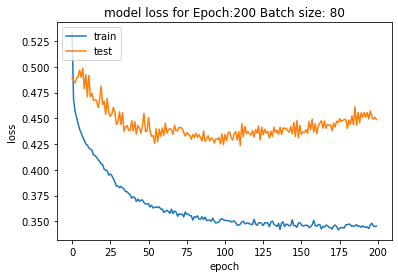

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss for Epoch:200 Batch size: 80")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()


**Get items rated by the user and Recommended items**

In [ ]:

def get_rated_items_by_user(user_id):
    items_rated = df[df.reviewerID == user_id]
    # items_rated = df[items_rated["asin"].unique()]
    # print("items_rated : \n", items_rated)
    return items_rated


def get_items_not_rated_by_user(user_id, items_rated_by_user):
    items_not_rated_by_user = df[~df["asin"].isin(items_rated_by_user.asin.values)]["asin"]
    items_not_rated_by_user_unique = list(set(items_not_rated_by_user).intersection(set(item2item_encoded.keys())))
    items_not_rated_by_user_encoded = [[item2item_encoded.get(x)] for x in items_not_rated_by_user_unique]

    # print(" items_not_rated_by_user : \n", items_not_rated_by_user)

    # returns indices of items: eg: [0, 5, 6]
    return items_not_rated_by_user_encoded


def get_items_with_model_predictions(user_id, items_not_rated_by_user_encoded):
    user_id_encoded = user2user_encoded.get(user_id)

    user_item_array = np.hstack(
        ([[user_id_encoded]] * len(items_not_rated_by_user_encoded), items_not_rated_by_user_encoded)
    )

    ratings = model.predict(user_item_array).flatten()
    # print("ratings is ", ratings)
    # print("ratings is ", ratings.argsort())
    # print("user_item_array one col : ", user_item_array[:, 1])
    # print("user_item_array : ", user_item_array)

    return ratings


def get_top_predicted_items_for_user(user_id, predictions, items_not_rated_by_user_encoded, top_k=15):
    top_ratings_indices = predictions.argsort()[-top_k:][::-1]
    # print("top_ratings_indices: ", top_ratings_indices)
    recommended_item_ids = [
        item_encoded2item.get(items_not_rated_by_user_encoded[x][0]) for x in top_ratings_indices
    ]

    for asin, prediction_index in zip(recommended_item_ids, top_ratings_indices):
      print("asin: ", asin, " prediction: ", predictions[prediction_index])

    return recommended_item_ids

def get_top_items_rated_by_user(user_id, items_rated_by_user, top_k=15):
    top_user_items = items_rated_by_user.sort_values(by="overall", ascending=False).head(15)
    # print("top_user_items: \n", top_user_items)
    for row in top_user_items.itertuples():
      print("asin: ", row.asin, " rating: ", row.overall)


    return list(top_user_items["asin"].unique())

######
# top_rated_items_by_user = get_top_rated_items_by_user(user_id)
user_id = "A31Z48BHHUTB0P"
# user_id = "AOX4RX9CAAHL4"

items_rated_by_user = get_rated_items_by_user(user_id)

items_not_rated_by_user_encoded = get_items_not_rated_by_user(user_id, items_rated_by_user)

predictions = get_items_with_model_predictions(user_id, items_not_rated_by_user_encoded)
print("=============================================")
print("top rated items by A31Z48BHHUTB0P")
print("=============================================")
top_rated_items_for_user = get_top_items_rated_by_user(user_id, items_rated_by_user)
print("=============================================")
print("top_rated_items_for_user: A31Z48BHHUTB0P :\n",top_rated_items_for_user)
print("=============================================")

print("top predicted items for A31Z48BHHUTB0P")
print("=============================================")
top_predicted_items_for_user = get_top_predicted_items_for_user(user_id, predictions, items_not_rated_by_user_encoded)
print("=============================================")


#####



top rated items by A31Z48BHHUTB0P
asin:  B002K6AHQY  rating:  5.0
asin:  B001B271Q2  rating:  5.0
asin:  B000CR4HJG  rating:  5.0
asin:  B002K6AHQY  rating:  5.0
asin:  B000NGI4QI  rating:  5.0
asin:  B00CNE2GOO  rating:  5.0
asin:  B002K6AHQY  rating:  4.0
top_rated_items_for_user: A31Z48BHHUTB0P :
 ['B002K6AHQY', 'B001B271Q2', 'B000CR4HJG', 'B000NGI4QI', 'B00CNE2GOO']
top predicted items for A31Z48BHHUTB0P
asin:  B00110S3GG  prediction:  0.999954
asin:  B000VNIZGM  prediction:  0.9999502
asin:  B00A9TZMQE  prediction:  0.99986625
asin:  B0015VN6V8  prediction:  0.99984
asin:  B000ULD9XE  prediction:  0.99983335
asin:  B00120RRYO  prediction:  0.99983025
asin:  B000W6244M  prediction:  0.99982786
asin:  B000XPTFMG  prediction:  0.9998221
asin:  B004N2SQUC  prediction:  0.9997701
asin:  B000Z657ZW  prediction:  0.99975926
asin:  B00166M14A  prediction:  0.9996929
asin:  B00NZ1FH86  prediction:  0.9996536
asin:  B0016A7QNC  prediction:  0.9996474
asin:  B0009DSONI  prediction:  0.999504

**Fetch the metadata**

In [ ]:
!wget http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Luxury_Beauty.json.gz

--2020-08-10 17:59:49--  http://deepyeti.ucsd.edu/jianmo/amazon/metaFiles/meta_Luxury_Beauty.json.gz
Resolving deepyeti.ucsd.edu (deepyeti.ucsd.edu)... 169.228.63.50
Connecting to deepyeti.ucsd.edu (deepyeti.ucsd.edu)|169.228.63.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7390423 (7.0M) [application/octet-stream]
Saving to: ‘meta_Luxury_Beauty.json.gz’

meta_Luxury_Beauty. 100%[===================>]   7.05M  6.02MB/s    in 1.2s    

2020-08-10 17:59:51 (6.02 MB/s) - ‘meta_Luxury_Beauty.json.gz’ saved [7390423/7390423]



In [ ]:
def parse(path):
  # asin_metadata = {}
  arr = []
  g = gzip.open(path, 'rb')
  for l in g:
    # data = json.loads(l)
    # arr.append(data)
    yield json.loads(l)
  
  return arr

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    # df[i] = d
    df[d["asin"]] = d
    # i += 1

  # return pd.DataFrame.from_dict(df, orient='index')
  return df

# asin_metadata = parse2('meta_Luxury_Beauty.json.gz')
asin_metadata = getDF('meta_Luxury_Beauty.json.gz')


**Formulate a Json to show the Recommended Items on UI**

In [ ]:
# asin_metadata.head()
# print(asin_metadata.head())
print(json.dumps(asin_metadata["B00120RRYO"]))

{"category": [], "tech1": "", "description": ["A refreshing, oil-absorbing powder infused with soft fragrance is perfect whenever locks need a lift. As the powder reaches your roots, it adds much-needed volume without weighing hair down. Jade blossom is lightly scented with a cool, green tea floral."], "fit": "", "title": "stila Hair Refresher Dry Shampoo, 2.6 oz.", "also_buy": [], "image": ["https://images-na.ssl-images-amazon.com/images/I/41993-Y4nOL._SX50_SY65_CR,0,0,50,65_.jpg", "https://images-na.ssl-images-amazon.com/images/I/41RfwTj4jTL._SX50_SY65_CR,0,0,50,65_.jpg"], "tech2": "", "brand": "", "feature": [], "rank": "504,275 in Beauty & Personal Care (", "also_view": ["B00FFILCPO", "B075J6DXB3", "B01MD06Q2H"], "details": {"\n    Product Dimensions: \n    ": "4 x 5 x 6 inches ; 2.56 ounces", "Shipping Weight:": "2.9 ounces", "Domestic Shipping: ": "Item can be shipped within U.S.", "International Shipping: ": "This item is not eligible for international shipping.", "ASIN:": "B001

In [ ]:
print("asin_metadata : " , asin_metadata["B00120RRYO"])

asin_metadata :  {'category': [], 'tech1': '', 'description': ['A refreshing, oil-absorbing powder infused with soft fragrance is perfect whenever locks need a lift. As the powder reaches your roots, it adds much-needed volume without weighing hair down. Jade blossom is lightly scented with a cool, green tea floral.'], 'fit': '', 'title': 'stila Hair Refresher Dry Shampoo, 2.6 oz.', 'also_buy': [], 'image': ['https://images-na.ssl-images-amazon.com/images/I/41993-Y4nOL._SX50_SY65_CR,0,0,50,65_.jpg', 'https://images-na.ssl-images-amazon.com/images/I/41RfwTj4jTL._SX50_SY65_CR,0,0,50,65_.jpg'], 'tech2': '', 'brand': '', 'feature': [], 'rank': '504,275 in Beauty & Personal Care (', 'also_view': ['B00FFILCPO', 'B075J6DXB3', 'B01MD06Q2H'], 'details': {'\n    Product Dimensions: \n    ': '4 x 5 x 6 inches ; 2.56 ounces', 'Shipping Weight:': '2.9 ounces', 'Domestic Shipping: ': 'Item can be shipped within U.S.', 'International Shipping: ': 'This item is not eligible for international shipping.

In [ ]:
print("top_predicted_items_for_user :", top_predicted_items_for_user)

top_predicted_items_for_user : ['B00110S3GG', 'B000VNIZGM', 'B00A9TZMQE', 'B0015VN6V8', 'B000ULD9XE', 'B00120RRYO', 'B000W6244M', 'B000XPTFMG', 'B004N2SQUC', 'B000Z657ZW', 'B00166M14A', 'B00NZ1FH86', 'B0016A7QNC', 'B0009DSONI', 'B0012H6Y28']


In [ ]:
# recommended_items_json = {}
def get_item_details_json(items, json_type):
  items_arr = []
  for item in items:
    items_json = {}
    metadata_dict = asin_metadata[item]
    items_json["json_type"] = json_type
    items_json["asin"] = metadata_dict["asin"]
    items_json["title"] = metadata_dict["title"]
    items_json["description"] = metadata_dict["description"]
    
    new_images = list(map(lambda i: str.replace(i, "_SX50_SY65_CR,0,0,50,65_", "_SY500_"), metadata_dict["image"]))
    items_json["images"] = new_images
    items_arr.append(items_json)

  return json.dumps(items_arr)
  

**Items Top rated by the user Json**

In [ ]:
print("recommended_items json array : \n", get_item_details_json(top_predicted_items_for_user, "predicted_items"))


recommended_items json array : 
 [{"json_type": "predicted_items", "asin": "B00110S3GG", "title": "theBalm Overshadow", "description": ["Overshadows add a luxe look to the lid, taking the most subtle daytime shadow and amping it up for nighttime fun. Apply over your favorite shadow to give a fresh look to your staple shadow colors."], "images": ["https://images-na.ssl-images-amazon.com/images/I/51GEuJ6nu9L._SY500_.jpg", "https://images-na.ssl-images-amazon.com/images/I/51zzxTE3jVL._SY500_.jpg", "https://images-na.ssl-images-amazon.com/images/I/61xIrQd9RhL._SY500_.jpg", "https://images-na.ssl-images-amazon.com/images/I/21pDXHqy0TL._SY500_.jpg", "https://images-na.ssl-images-amazon.com/images/I/61tWj-HNVEL._SY500_.jpg"]}, {"json_type": "predicted_items", "asin": "B000VNIZGM", "title": "Paul Mitchell Super Skinny Serum,8.5 Fl Oz", "description": ["Smoothes and conditions unruly hair Smoothes and protects hair with incredible shine. Helps reduce blow-dry time Contains our unique Super Skin

**Top 15 predicted items Json**

In [ ]:
print("Top rated items by a user : ", get_item_details_json(top_rated_items_for_user, "existing_rated_items"))


Top rated items by a user :  [{"json_type": "existing_rated_items", "asin": "B002K6AHQY", "title": " CND Vinylux Weekly Nail Polish, Rock Royalty, .5 oz", "description": ["Vinylux weekly polish and weekly top coat are a system that is uniquely design to work together. Patent-pending pro-light technology creates a powerful network of cross-linked polymer bonds that build resistance to chips, and enhance durability with exposure to natural light over time.", "Creative Nail Design, Inc. (CND) is the global leader in professional nail, hand and foot beauty  including SHELLAC Brand 14+ Day Nail Color.", "<img alt=\"CND Vinylux Longwear Nail Polish Top Coat gel like shine with Keratin Vitamin E Jojoba Oil\" src=\"https://m.media-amazon.com/images/S/aplus-media/vc/c4212b28-5a17-4627-8a32-9731640105dc._CR0,0,1250,1250_PT0_SX300__.jpg\" class=\"a-spacing-mini\">\n    \n\n\n                            <br/>", "<img alt=\"CND Vinylux Longwear Nail Polish Top Coat gel like shine with Keratin Vitam